In [0]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
from skimage.transform import resize, rescale, rotate, setup, warp
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.patches as patches

from skimage.color import rgb2gray

import PIL
from PIL import Image

from google.colab import output

In [2]:
%cd /content/
if(os.path.isdir('/content/Lithuanian_OCR') == False):
  !git clone https://github.com/PauliusMilmantas/Lithuanian_OCR

/content
Cloning into 'Lithuanian_OCR'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 3546 (delta 2), reused 15 (delta 2), pack-reused 3531
Receiving objects: 100% (3546/3546), 115.26 MiB | 10.58 MiB/s, done.
Resolving deltas: 100% (579/579), done.


In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, hidden3_size)
        self.relu3 = nn.ReLU()      
        self.fc4 = nn.Linear(hidden3_size, hidden4_size)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden4_size, hidden5_size)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden5_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        out = self.relu2(out)
        out = self.fc3(out)        
        out = self.relu3(out)
        out = self.fc4(out)        
        out = self.relu4(out)
        out = self.fc5(out)        
        out = self.relu5(out)
        out = self.fc6(out)
        return out

In [0]:
network = Net(4096, 2500, 1500, 500, 100, 50, 3)
network.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/model.pth'))
network.eval()

optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.6)
optimizer.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/optimizer.pth'))

criterion = nn.MSELoss()

In [0]:
def proccess_image(path):
  image = io.imread(path)
  image = rgb2gray(image)
  image = resize(image, (64, 64))
  
  return torch.tensor(image)

In [0]:
def get_max_from_tensor(data):
  maxVal = data[0]
  maxId = 0
  for i in range(len(data)):
    if(data[i] > maxVal):
      maxVal = data[i]
      maxId = i

  return maxId + 1

In [0]:
def get_result(data):
  idx = get_max_from_tensor(data) - 1

  if(data[idx] > 0 and data[idx] < 1):
    return idx + 1
  # No object found
  elif(data[idx] <= 0):
    return 0
  # Best guess is that there is no object
  else:
    return 0

In [0]:
def find_in_array(arr, element):
  idx = 0
  found = []

  for el in arr:
    if(el == element):
      found.append(idx)
    idx += 1

  return found

In [0]:
def find_probability(output, idx):
  output = output.detach().numpy()
  probability = output[idx][0]
  for i in range(len(output)):
    if i != idx[0]:
      probability -= output[i]
  return probability

In [0]:
def prepare_image_for_network(image):
  image = resize(image, (64, 64))

  return image

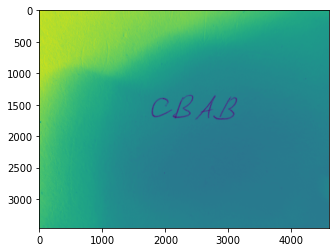

In [17]:
image = io.imread('/content/Lithuanian_OCR/Examples/example.jpg')

image = rotate(image, 180)
image = rgb2gray(image)
plt.imshow(image)

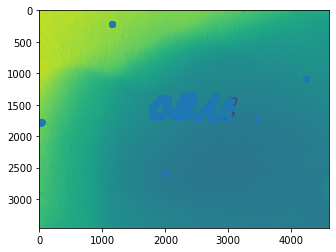

449


In [23]:
registered_x = []
registered_y = []

for y in range(image.shape[0]):
  last_val = image[y][0]
  for x in range(image.shape[1]):
    if(abs(last_val - image[y][x]) >= 0.1):
      registered_x.append(x)
      registered_y.append(y)
    last_val = image[y][x]

implot = plt.imshow(image)
plt.scatter(registered_x, registered_y)
plt.show()

print(len(registered_x))

In [0]:
class Letter():
  def __init__(self, element, start_x, end_x, start_y, end_y, prob):
    self.element = element
    self.start_x = start_x
    self.end_x = end_x
    self.start_y = start_y
    self.end_y = end_y
    self.prob = prob

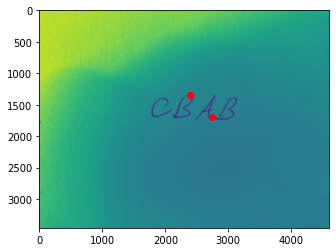

2388, 1350


In [34]:
step = 100
score_treshold = 0.7
max_size = 350

x = registered_x[10]
y = registered_y[10]

implot = plt.imshow(image)
plt.scatter([x, x+max_size], [y, y+max_size], c='r')
plt.show()

print("{}, {}".format(x, y))

In [15]:
print(len(letters))

NameError: ignored